<a href="https://colab.research.google.com/github/TottiPuc/Machine_learning/blob/master/RNN_con_TF_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recurrent Neural Network usando keras para predicción de valoraciones de una APP

En este notebook crearemos una RNN para hacer un análisis de texto y saber si la valoracion de una APP es positiva o negariva

In [0]:
import tensorflow as tf
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import files
uploaded = files.upload()

Saving original.csv to original.csv


In [125]:
df = pd.read_csv('original.csv')
print(df.shape)

(64295, 5)


In [126]:
#verificamos si el dataset esta bien cargado
df.head()


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


##Pre procesado de datos

Como se puede observar el dataset contiene campos que no aportan información o que estan nulos para eso hacemos un pre procesado de los datos eliminando esos registros

In [127]:
df = df.dropna()
df.shape

(37427, 5)

In [128]:
# como se puede ver en el shape se eliminarón casi la mitad de los registros que contenian NaN. 
#verificamos si efectivamente se borraron los NaN
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [129]:
#seleccionamos las filas deinteres 
df=df[['Translated_Review', 'Sentiment']]
df.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


Analizamos la frecuencia del tipo de sentimiento del total del dataset, para saber de manera global si la APP esta siendo bien o mal valorada

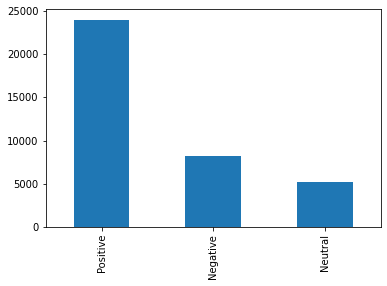

In [130]:
df['Sentiment'].value_counts().plot(kind='bar')

Solo trabajaremos con las calificaciones positivas y negativas

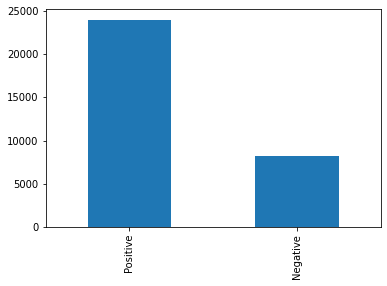

In [131]:
df = df.drop(df[df['Sentiment']=='Neutral'].index)
df['Sentiment'].value_counts().plot(kind='bar')

Realizamos un tratatiento de palabras extrañas numero signos de puntuación o cosas que puedan entorpecer el análisis

In [0]:
def tratamiento (frase):

    # Eliminar símbolos de puntuación y números
    frases = re.sub('[^a-zA-Z]', ' ', frase)
    
    # Eliminar carácteres sueltos
    frases = re.sub(r"\s+[a-zA-Z]\s+", ' ', frases)
    
    # Eliminar espacios excesivos
    frases = re.sub(r'\s+', ' ', frases)
    
    # Convertir a minúscula
    frases = frases.lower()
    return frases


In [0]:
#aplicamos la funcion de tratamiento a la fila Translated_review del dataset
df['Translated_Review'] = df['Translated_Review'].apply(lambda frase: tratamiento(frase))

#Preparación de los datos de entrenamiento y teste

In [0]:
x = df['Translated_Review']
y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()

In [136]:
y

array([1, 1, 1, ..., 0, 1, 0])

usamos la libreria sklear para dividir el conjunto de datos

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

Ahora se localiza las N palabras mas frecuentes y se establece un largo adecauado para cada frase de entrada a la red ( convertir las palabras en vectores numericos word2vec)

In [138]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
NUMBER_OF_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [0]:
from keras.preprocessing.sequence import pad_sequences
# se rellena con ceros con la tecnica padding aquellas palabras que no sean de las mas frecuentes
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_LEN)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_LEN)

array([[2948,    2,    0, ...,    0,    0,    0],
       [7124,   10,    2, ...,    0,    0,    0],
       [  52,   11,   46, ...,    0,    0,    0],
       ...,
       [ 178,  400,   94, ...,    0,    0,    0],
       [  18,  296,  216, ...,    0,    0,    0],
       [ 158,  613, 3349, ...,    0,    0,    0]], dtype=int32)

## Generando la arquitectura de la Recurrent neural network

In [0]:
VOCABULARY_SIZE = NUMBER_OF_WORDS
EMBEDDING_SIZE = 128

In [147]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE, input_shape=(x_train.shape[1],)))

model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

#En units, se debe especificar cuantas clases tenemos. 
model.add(tf.keras.layers.Dense(units=np.unique(y_train).shape[0], activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________


Entrenamos la red

In [149]:
model.fit(x_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
202/202 [==============================] - 5s 24ms/step - loss: 0.5707 - sparse_categorical_accuracy: 0.7428
Epoch 2/10
202/202 [==============================] - 5s 23ms/step - loss: 0.5707 - sparse_categorical_accuracy: 0.7428
Epoch 3/10
202/202 [==============================] - 5s 23ms/step - loss: 0.5706 - sparse_categorical_accuracy: 0.7428
Epoch 4/10
202/202 [==============================] - 5s 22ms/step - loss: 0.5701 - sparse_categorical_accuracy: 0.7428
Epoch 5/10
202/202 [==============================] - 5s 22ms/step - loss: 0.5658 - sparse_categorical_accuracy: 0.7428
Epoch 6/10
202/202 [==============================] - 5s 22ms/step - loss: 0.5693 - sparse_categorical_accuracy: 0.7391
Epoch 7/10
202/202 [==============================] - 5s 22ms/step - loss: 0.5667 - sparse_categorical_accuracy: 0.7428
Epoch 8/10
202/202 [==============================] - 5s 22ms/step - loss: 0.5585 - sparse_categorical_accuracy: 0.7428
Epoch 9/10
202/202 [====================

Evaluamos el modelo para ver su performance

In [153]:
test_loss, test_acurracy = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f} %".format(test_acurracy *100))

202/202 [==============================] - 1s 4ms/step - loss: 0.5687 - sparse_categorical_accuracy: 0.7473
Test accuracy: 74.73 %
